In [ ]:
!pip install obci_readmanager

     |████████████████████████████████| 61kB 3.4MB/s 
     |████████████████████████████████| 6.2MB 7.7MB/s 
  Created wheel for mne: filename=mne-0.17.2-cp37-none-any.whl size=6194576 sha256=f48e2be49fef37f3564135bb5f34d7963a66113dc9e7dff20d596cf36b265e8c
  Stored in directory: /root/.cache/pip/wheels/e4/be/8b/6b737d272fb91d42e7ac5d61cc93227df7d71944e0e0eb15dd
Successfully built mne


In [ ]:
from obci_readmanager.signal_processing.read_manager import ReadManager as rm
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from obci_readmanager.signal_processing.smart_tags_manager import SmartTagsManager
from obci_readmanager.signal_processing.tags.smart_tag_definition import (
                    SmartTagDurationDefinition,
                    SmartTagEndTagDefinition)
import math
from math import floor, ceil

In [ ]:
xml = "/content/kasia_z_ksiazka.xml"
raw = "/content/kasia_z_ksiazka.raw"
tag = "/content/kasia_z_ksiazka.tag"
mgr = rm(xml,raw,tag)

sampling = float(mgr.get_param("sampling_frequency"))
num_of_channels = int(mgr.get_param("number_of_channels"))
channels_names = mgr.get_param("channels_names")

mgr_info = (sampling, num_of_channels, channels_names)
for i in mgr_info:
  print(i)

syg_raw = mgr.get_microvolt_samples()

2021-05-24 07:56:11,122 - data_source - INFO - All data set requested for the first time. Start reading all data from the file...


2048.0
2
['Bip25', 'TSS']


Text(0.5, 1.0, 'Raw Signal')

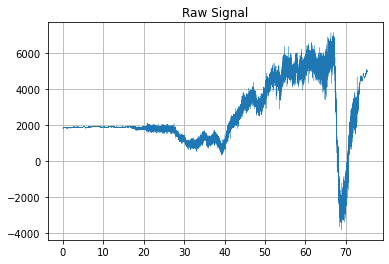

In [ ]:
raw_signal = syg_raw[0]
t = np.arange(0,len(raw_signal)/sampling, 1/sampling)

plt.plot(t, raw_signal, linewidth=0.3)
plt.grid()
plt.title('Raw Signal')

# Filtrowanie

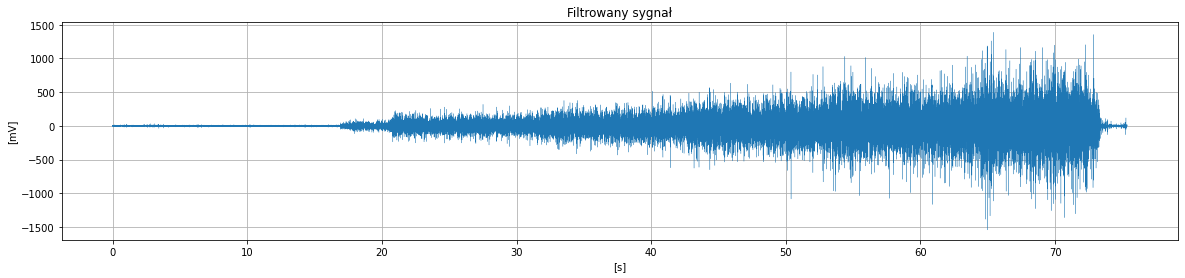

In [ ]:
a, b = signal.butter(3, 25, btype='highpass', fs=sampling)
e, f = signal.iirnotch(50/2048, 30, fs=2.0)

filtered_signal = signal.filtfilt(a, b, raw_signal, axis=0)
filtered_signal = signal.filtfilt(e, f, filtered_signal, axis=0)

plt.figure(figsize=(20,4))
plt.plot(t, filtered_signal, linewidth=0.3)
plt.grid()
plt.ylabel('[mV]')
plt.title('Filtrowany sygnał')
plt.xlabel('[s]')
plt.show()

# Pobieranie tagów

In [ ]:
tags_all = mgr.get_tags('ksiazka')
tags = []
for i in range(len(tags_all)):
  tags.append((tags_all[i]['start_timestamp'],tags_all[i]['end_timestamp']))

# Wyznaczanie średniej dla wzrastającej liczby książek


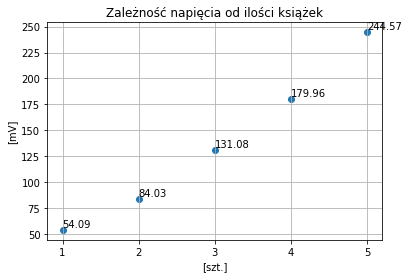

In [ ]:
means = []
for tag in tags:
  means.append(np.mean(abs(filtered_signal[int(tag[0]*sampling):int(tag[1]*sampling)])))

plt.grid()
plt.scatter(np.arange(1,len(means)+1,1), means)
for i, mean in enumerate(means):
  plt.annotate(round(mean,2), [i+1, mean+3])
plt.xticks(np.arange(1,len(means)+1,1))
plt.title('Zależność napięcia od ilości książek')
plt.ylabel('[mV]')
plt.xlabel('[szt.]')
plt.show()

# Porównanie widm

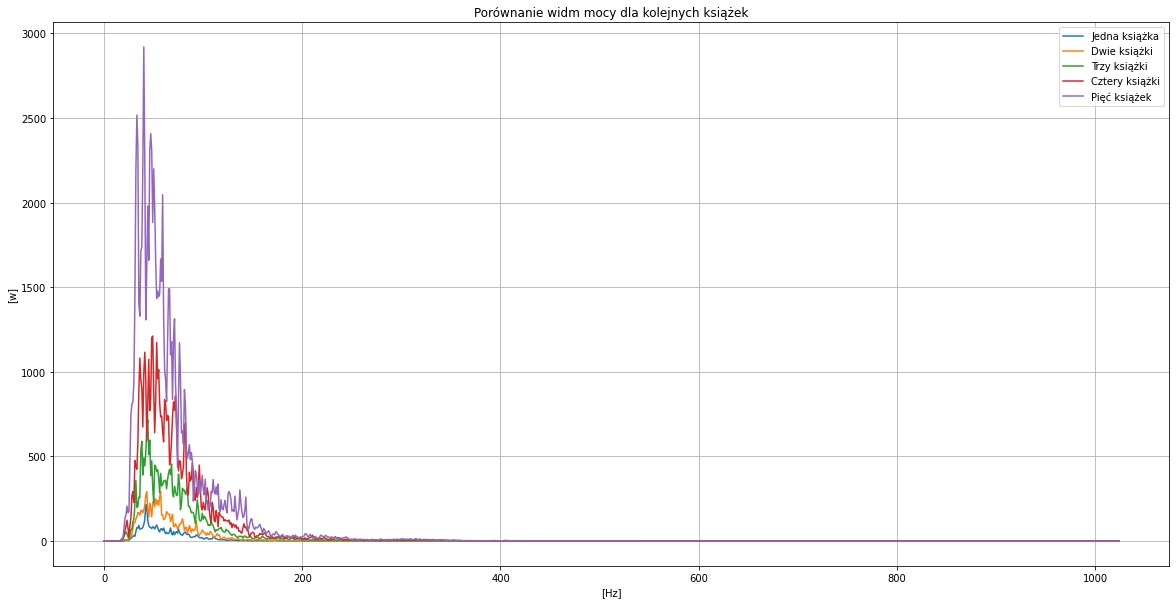

In [ ]:
spectrums = []
for tag in tags:
  current_signal = filtered_signal[int(tag[0]*sampling):int(tag[1]*sampling)]
  f, P = signal.welch(current_signal, sampling, window="hann", nperseg=sampling, noverlap=sampling/2)
  spectrums.append((f, P))

plt.figure(figsize=(20,10))
for spectrum in spectrums:
  plt.plot(spectrum[0], spectrum[1])
plt.title('Porównanie widm mocy dla kolejnych książek')
plt.xlabel('[Hz]')
plt.ylabel('[w]')
plt.legend(['Jedna książka','Dwie książki', 'Trzy książki', 'Cztery książki', 'Pięć książek'])
plt.grid()
plt.show()